In [6]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB
import time
import matplotlib.pyplot as plt
import math
import networkx as nx
from sklearn.linear_model import LinearRegression

In [92]:
def cpm(N,S,T):
    temp=[]
    for i in range(N-1):
        for k in S[i]:
            temp.append((i,k,{"cost":T[i,0]}))
    DG = nx.DiGraph(temp)
    temp=nx.dag_longest_path(DG)
    s=0
    for i in temp:
        s=s+T[i][0]
    return int(s)

In [142]:
#Model has fixed size
def model(J,H,N):
    np.random.seed(2022)
######################DATA PREPARATION######################
    env = gp.Env(empty=True)
    #env.setParam("OutputFlag",0)
    env.start()


    model=gp.Model(env=env)
    FOC=100+np.random.rand()*(1000-100)
    MOB=2000+np.random.rand()*(20000-2000)
    OB=np.random.rand()
    OP=np.random.rand()
    OV=np.random.rand()
    AP=5000+(50000-5000)*np.random.rand()
    
   
#Parameters taken by the data (r1)
    
    S=np.zeros(N, dtype=object)
    for i in range(N-1):
        temp=np.random.randint(0,N-i-1,1)
        S[i]=sorted(np.random.randint(i+1,N,temp).tolist())
    S[N-1]=[]
    M=np.zeros(N, dtype=object)
    for i in range(N):
        M[i]=[0,1,2]
    T=np.zeros([N,3],dtype=np.int64)
    for i in range(N):
        T[i,0]=np.random.randint(1,5,1)
        for j in range(1,3):
            T[i,j]=np.random.randint(T[i,0],5,1)
        C=np.zeros([N,3],dtype=np.int64)
    for i in range(N):
        for j in range(3):
            C[i][j]=np.random.randint(1,5,1)
    MMF=np.zeros([N,3],dtype=np.int64)
    for i in range(N):
        for j in range(3):
            MMF[i,j]=C[i,0]/C[i,j]
    print(S[0])
    Wmin=cpm(N,S,T)
    Wmax=Wmin+J

    if H==0:
        #W=model.addVar(name="W")
        CL=18000
    
    if H==1:
        CL=model.addVar(name="CL",lb=0)
        W=model.addVar(name="W")

    if H==2:
        #W=Wmax
        CL=18000

    if H==3:
        #W=Wmax
        CL=18000

    
    
    LP=np.random.randint(1,Wmax)
    LR=np.random.randint(1,Wmax)
    R=np.random.randint(1,Wmax)
    RP=np.random.rand()
    rW=np.random.rand()
    V=np.random.randint(1,Wmax)


    DCsum=np.sum(C[:,0])#Equation 1 
    VOCsum=OV*DCsum# Equation 2
    FOCsum=DCsum*Wmax# Equation 3
    PM=OP*(DCsum+VOCsum+FOCsum+MOB)#Equation 4
    BC=OB*(DCsum+VOCsum+FOCsum+MOB+PM)#Equation 5
    BP=DCsum+VOCsum+FOCsum+MOB+PM+BC#Equation 6
    MU=BP/DCsum#Equation 7

          
    
    #Equation from 7 to 20 are not in the model and equation from 21 to 22 are not used because of the fixed sizde
    x = model.addVars(N,N,Wmax+1, vtype=GRB.BINARY, name="x") #equation 45
    DC = model.addVars(N,Wmax+1, name="dc")
    EV = model.addVars(N,math.ceil(Wmax/R)*R+1, name="ev")
    TE = model.addVars(Wmax+1, name="te")
    I = model.addVars(math.ceil(Wmax/R)*R+1, name="I")
    P = model.addVars(math.ceil(Wmax/R)*R+LP+1, name="P")
    K=math.ceil(Wmax/R)
    y = model.addVars(K+1, vtype=GRB.BINARY, name="y")#equation 47
    temp=model.addVar(vtype=GRB.BINARY, name="temp")
    Mg=model.addVar(name="Mg")
    Z=model.addVar(name="Z")
    IB = model.addVars(Wmax+1, name="IB")
    B = model.addVars(Wmax+1, name="B")
    IL = model.addVars(Wmax+1, name="IL") 
    alpha= model.addVars(Wmax+1, vtype=GRB.BINARY, name="alpha") #equation 48

    model.addConstrs(gp.quicksum(x[i,j,k] for j in M[i] for k in range(1,Wmax+1))==1 for i in range(N))#equation 23
    #model.addConstrs(gp.quicksum((k+T[i,j])*x[i,j,k] for j in M[i] for k in range(1,Wmax+1))<gp.quicksum(k*x[q,j,k] for j in M[q] for k in range(1,Wmax+1)) for q in S[i] for i in range(N)) #equation 24
    #model.addConstrs(gp.quicksum((k+T[i,j])*x[i,j,k] for j in M[i] for k in range(1,Wmax+1))<=W for i in range(N) if len(S[i])==0) #equation 25
    #model.addConstrs(DC[i,k]==gp.quicksum(C[i,j]/T[i,j]*x[i,j,t] for t in range(max(1,k-T[i,j]),k+1) for j in M[i]) for i in range(N) for k in range(1,Wmax+1)) #equation 26
    #model.addConstrs(TE[k]==FOC+(1+OV)*gp.quicksum(DC[i,k] for i in range(N)) for k in range(1,Wmax+1)) #equation 27
    #model.addConstr(TE[0]==MOB+BC)
    #model.addConstrs(EV[i,k]==gp.quicksum(MMF[i,j]*DC[i,k] for j in M[i] for t in range(max(1,k-T[i,j]),k+1)) for i in range(N) for k in range(1,Wmax+1)) #equation 28
    #model.addConstrs(EV[i,k]==0 for i in range(N) for k in range(Wmax+1,math.ceil(Wmax/R)*R+1)) #equation 28
    model.addConstrs(I[k]==MU*gp.quicksum(EV[i,t] for t in range(k-R+1,k+1) for i in range(N)) for in range(R,(math.ceil(Wmax/R)+1)*R,R) #equation 29
    #model.addConstrs(I[k]==0 for k in set(range(math.ceil(Wmax/R)*R))-set(templist))k in range(R,math.ceil(Wmax/R)*R,R)
    #templist=[k for k in range(R+LP,math.ceil(Wmax/R)*R,R)]
    #templist.append(math.ceil(Wmax/R)*R+LP)
    #model.addConstrs(P[k]==RP*I[k-LP]-gp.quicksum(AP*y[n]/n for n in range(1,K+1)) for k in templist) #equation 30
    #model.addConstrs(P[k]==0 for k in set(range(math.ceil(Wmax/R)*R+LP+1))-set(templist)) 
    #model.addConstr(R*Z>=W) #equation 31
    #model.addConstr(R*Z<=W+R-1) #equation 32
    #model.addConstr(gp.quicksum(n*y[n] for n in range(K+1))==Z) #equation 33-34
    #model.addConstr(B[0]==AP-TE[0]) #equation 35
    #model.addConstrs(B[k]==B[k-1]-TE[k]+P[k-1]-IB[k] for k in range(1,Wmax+1)) #equation 36
    #templist=[k for k in range(V,Wmax,V)]
    #templist.append(Wmax)
    #model.addConstrs(IB[k]==rW*gp.quicksum(IL[t] for t in range(max(1,k-V+1),k+1)) for k in templist) #equation 37
    #model.addConstrs(B[k-1]-TE[k-1]<=(1-alpha[k])*Mg for k in range(1,Wmax+1))#equation 38
    #model.addConstrs(B[k-1]-TE[k-1]>=-alpha[k]*Mg for k in range(1,Wmax+1))#equation 39
    #model.addConstrs(IL[k]>=0  for k in range(1,Wmax+1))
    #model.addConstrs(IL[k]>=-(B[k-1]-TE[k])+(alpha[k]-1)*Mg for k in range(1,Wmax+1)) #equation 41
    #model.addConstrs(IL[k]<=-(B[k-1]-TE[k])+(1-alpha[k])*Mg for k in range(1,Wmax+1)) #equation 42
    #model.addConstrs(IL[k]<=alpha[k]*Mg  for k in range(1,Wmax+1))#equation 43
    #model.addConstrs(B[k]<=CL for k in range(1,Wmax+1))
    #model.addConstr(Z>=0) 
    #model.addConstr(Z<=Mg)
 
    if H==0:
        print("ciao")
        #model.setObjective(W,GRB.MINIMIZE)   

    if H==1:
        model.setObjective(CL,GRB.MINIMIZE)   
    
    if H==2:
        model.setObjective(gp.quicksum(TE[k] for k in range(1,Wmax+1)), GRB.MINIMIZE)
        
    if H==3:
        model.setObjective(B[Wmax], GRB.MAXIMIZE)
    model.optimize()



SyntaxError: invalid syntax (333705000.py, line 107)

In [143]:
model(0,0,20)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-06
[2, 7, 9, 9, 12, 12, 15, 17, 17]
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 20 rows, 9875 columns and 1260 nonzeros
Model fingerprint: 0x803d0f4e
Model has 11 quadratic constraints
Variable types: 1040 continuous, 8835 integer (8835 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 20 rows and 9423 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Best objective -, best bound -, gap -


GurobiError: Quadratic equality constraints are non-convex. Set NonConvex parameter to 2 to solve model.

# Scalability analysis

In [53]:
times=np.zeros([30,4])
N=4
for i in range(30):
    for j in range(4):
        timeold=time.time()
        temp=algorithm(j,N+i)
        times[i][j]=time.time()-timeold

NameError: name 'algorithm' is not defined

## Model 0 : W minimization

In [33]:
lin = LinearRegression().fit(np.array([i for i in range(4,34)]).reshape(-1,1), times[0:30,0])
print("Linear score:",lin.score(np.array([i for i in range(4,34)]).reshape(-1,1),times[0:30,0]))
quad = LinearRegression().fit(np.array([[i for i in range(4,34)],[i**2 for i in range(4,34)]]).T, times[0:30,0])
print("Quadratic score:", quad.score(np.array([[i for i in range(4,34)],[i**2 for i in range(4,34)]]).T,times[0:30,0]))

Linear score: 0.8770773428946552
Quadratic score: 0.8878807523096336


Quadratic model is similar to linear model, so true model is approximately linear

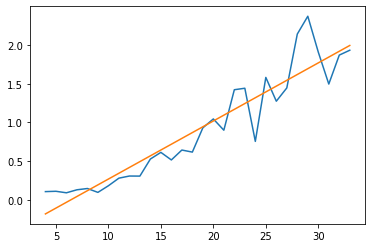

In [34]:
plt.plot([i for i in range(4,34)],times[0:30,0])
plt.plot([i for i in range(4,34)],np.array([i for i in range(4,34)])*lin.coef_+lin.intercept_)

# Model 1: CL minimization

In [36]:
lin = LinearRegression().fit(np.array([i for i in range(4,34)]).reshape(-1,1), times[0:30,1])
print("Linear score:",lin.score(np.array([i for i in range(4,34)]).reshape(-1,1),times[0:30,1]))
quad = LinearRegression().fit(np.array([[i for i in range(4,34)],[i**2 for i in range(4,34)]]).T, times[0:30,1])
print("Quadratic score:", quad.score(np.array([[i for i in range(4,34)],[i**2 for i in range(4,34)]]).T,times[0:30,1]))

Linear score: 0.7797072413290047
Quadratic score: 0.7802491390827204


Quadratic model is similar to linear model, so true model is approximately linear